Recommender Playlists
Exploration implementing recommender system techniques using Spotify playlist data:

Popularity Recommender: Recommend popular songs regardless of user's preferences
Content-based Recommender: Use song attributes (e.g. genre) to recommend similar songs
Collaborative Recommender: Predict what songs a user might be interested in based on a collection of preference information from multiple users
Hybrid Recommender: A hybrid approach generally outperforms a single model and can be used to overcome some of the common problems in recommender systems such as the cold start problem and the sparsity problem
HybridPopularity Recommender: An extension of the hybrid approach which applies weighting/mixes in songs based on popularity
For the purposes of this dataset we will focus on the playlist_tracks_df dataset and treat different playlists as different users. This is a strong approach for exploring recommendation techniques but leads to a problem the best way to recommend songs for our 'users' is based on genre (as my playlists tend to be genre-based).

In [1154]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import yaml
from scipy.stats import chi2_contingency

# Set maximum number of rows and columns displayed
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [1155]:
# Membaca data Anda
df = pd.read_csv('kpmi_data.csv')

# Menghapus baris di mana 'jobtitle' atau 'jobfield' adalah null
df = df.dropna()

# Drop columns
for i in range(1, 143):
    try:
        df.drop('q'+str(i), axis=1, inplace=True)
    except KeyError:
        print(f"Kolom 'q{i}' tidak ada di dataframe.")
# Menghapus kolom di mana terdapat nilai NA

# Menyimpan DataFrame yang telah dibersihkan
df

C:\Users\fairu\AppData\Local\Temp\ipykernel_11252\3279882507.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('kpmi_data.csv')


,jobtitle,jobfield,scale_e,scale_i,scale_s,scale_n,scale_t,scale_f,scale_j,scale_p,psychotype,satisfied
1,HR manager,Staff and training,16,22,17,16,23,11,22,15,ISTJ,1
2,HR manager,Staff and training,28,6,14,18,20,16,20,15,ENTJ,0
3,HR manager,Staff and training,28,10,22,10,16,14,22,12,ESTJ,1
4,HR manager,Staff and training,24,10,16,17,13,23,31,3,ENFJ,0
5,HR manager,Staff and training,25,12,17,13,23,11,10,25,ESTP,1
...,...,...,...,...,...,...,...,...,...,...,...,...
12617,Lawyer,Specialists,19,16,19,15,16,17,15,17,ESFP,0
12618,Lawyer,Specialists,5,32,25,9,11,23,29,8,ISFJ,1
12619,Lawyer,Specialists,25,14,15,16,18,22,9,25,ENFP,1
12620,Lawyer,Specialists,21,16,27,9,30,8,32,2,ESTJ,0


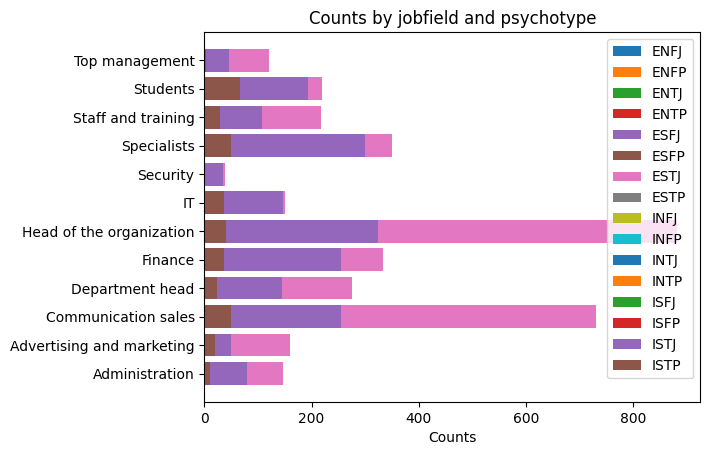

In [1156]:
import matplotlib.pyplot as plt

# Data Anda
contingency_table = pd.crosstab(df['jobfield'], df['psychotype'])

# Mendapatkan label dan data
jobfields = contingency_table.index
psychotypes = contingency_table.columns

# Membuat plot
fig, ax = plt.subplots()

# Membuat batang
for i, psychotype in enumerate(psychotypes):
    ax.barh(jobfields, contingency_table[psychotype], label=psychotype)

# Menambahkan beberapa detail
ax.set_xlabel('Counts')
ax.set_title('Counts by jobfield and psychotype')
ax.legend()

plt.show()


## Content-Based Filtering Explanation with Fuzzy Logic

### Overview

This implementation focuses on building a content-based recommendation system using a scale-based algorithm augmented with fuzzy logic. The approach involves leveraging personality scales, measuring various dimensions such as extraversion vs. introversion, sensing vs. intuition, thinking vs. feeling, and judging vs. perceiving. The goal is to provide job recommendations that align with Job preferences based on their psychometric profiles, incorporating fuzzy logic for enhanced flexibility in handling imprecise preferences.

### Process Explanation

#### 1. Normalization of Scales with Fuzzy Logic
   - The initial step involves normalizing each personality scale using Min-Max scaling, incorporating fuzzy logic to handle the inherent imprecision in psychometric measurements. This ensures a consistent range of values for each dimension, facilitating uniform access and calculations in subsequent steps.

#### 2. Weight Calculation for Each Scale
   - We calculate weights for each scale based on the number of jobs in the same field, introducing fuzzy logic to accommodate uncertainties in job preferences. This step emphasizes preferences that align with specific work environments, providing a nuanced weighting system that considers imprecise data.

#### 3. Job Profile Formation with Fuzzy Logic
   - Job profiles are formed by summing weighted scales for each personality type, integrating fuzzy logic to capture the vagueness in psychological tendencies. This creates a numerical representation of a Job's psychological profile in the context of jobs, accounting for imprecise preferences.

#### 4. Integration of MBTI and Job Profiles
   - Job profiles, enriched with fuzzy logic-enhanced scales, are seamlessly integrated into the main dataframe by merging them with job profiles. This integration ensures a holistic representation of Job and job preferences, considering uncertainties in both.

#### 5. Unique Job Profile Creation with Fuzzy Logic
   - Unique Job profiles are generated based on personality types, incorporating fuzzy logic to handle imprecision in the profiling process. Each profile includes fuzzy weighted values for each scale, forming the foundation for personalized recommendations that account for vagueness in Job preferences.

### Rationale

This approach was chosen because it not only utilizes detailed information about Job preferences, measured in terms of personality scales but also integrates fuzzy logic to enhance the system's flexibility in handling imprecise or vague data. The combination of Min-Max scaling and fuzzy logic ensures consistency and adaptability in representing and interpreting psychometric data. By incorporating fuzzy logic into the Job and job profile integration process, the system can deliver more accurate and tailored recommendations, accommodating the inherent uncertainties in Job preferences and psychometric measurements.


In [1157]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import numpy as np

class CBFRecommender:
    def __init__(self, df):
        self.df = df
        self.job_counts = df.groupby('jobfield')['psychotype'].value_counts()

    def get_fuzzy_scale(self, scale):
        scaler = MinMaxScaler()
        return scaler.fit_transform(self.df[[scale]])

    def get_weighted_scale(self, scale):
        return self.df['normalized_'+scale] * self.df.set_index(['jobfield', 'psychotype']).index.map(self.job_counts)

    def form_user_profile(self):
        user_profile = self.df.groupby('psychotype')[['weighted_scale_e', 'weighted_scale_i', 'weighted_scale_s', 'weighted_scale_n', 'weighted_scale_t', 'weighted_scale_f', 'weighted_scale_j', 'weighted_scale_p']].sum()
        scaler = MinMaxScaler()
        normalized_job_profile = pd.DataFrame(scaler.fit_transform(user_profile), columns=user_profile.columns, index=user_profile.index)
        return normalized_job_profile
    
    def recommend(self, input_psychotype):
        # Get unique user profile
        unique_user_profile = self.get_unique_user_profile(self.form_user_profile())

        # Calculate similarity scores and get top 5 recommendations
        recommendations = self.calculate_similarity_scores(unique_user_profile, input_psychotype)
        
        return recommendations
    
    def get_unique_user_profile(self, normalized_job_profile):
        return {
            psychotype:{
                'user_profile_'+scale: normalized_job_profile.loc[psychotype]['weighted_'+scale]
                for scale in ['scale_e', 'scale_i', 'scale_s', 'scale_n', 'scale_t', 'scale_f', 'scale_j', 'scale_p']
            } for psychotype in normalized_job_profile.index.unique()
        }

    def calculate_similarity_scores(self, unique_user_profile, psychotype):
        # Get the user profile for the specified psychotype
        user_profile = unique_user_profile[psychotype]

        # Reshape the user profile to a 2D array
        user_profile_2D = np.array(list(user_profile.values())).reshape(1, -1)

        # Calculate the cosine similarity between the user profile and all job profiles
        similarity_scores = cosine_similarity(job_profiles, user_profile_2D)

        # Add the similarity scores to the dataframe
        self.df['recommendation_score'] = similarity_scores

        recommendations = self.df.sort_values(by='recommendation_score', ascending=False).head(5)
        return recommendations[['jobfield', 'recommendation_score']]

    def process(self):
        # Normalize each scale
        for scale in ['scale_e', 'scale_i', 'scale_s', 'scale_n', 'scale_t', 'scale_f', 'scale_j', 'scale_p']:
            self.df['normalized_'+scale] = self.get_fuzzy_scale(scale)

        # Calculate weights for each scale based on the number of jobs in the same field
        for scale in ['scale_e', 'scale_i', 'scale_s', 'scale_n', 'scale_t', 'scale_f', 'scale_j', 'scale_p']:
            self.df['weighted_'+scale] = self.get_weighted_scale(scale)

        # Form user profile by summing scales in the weight matrix for each movie
        normalized_job_profile = self.form_user_profile()

        # Add job profile to the dataframe
        self.df = self.df.join(normalized_job_profile, on='psychotype', rsuffix='_job')

        # Get unique user profile
        unique_user_profile = self.get_unique_user_profile(normalized_job_profile)

        return self.df, unique_user_profile

# Initialize the CBFRecommender
user_profile = CBFRecommender(df)

# Process the dataframe and get unique user profile
df, unique_user_profile = user_profile.process()

# Calculate similarity scores and get top 5 recommendations
recommendations = user_profile.calculate_similarity_scores(unique_user_profile, 'INTJ')
recommendations


,jobfield,recommendation_score
1706,Finance,0.993099
3358,Finance,0.992180
11712,Staff and training,0.992076
12585,Specialists,0.992066
10436,Students,0.989000


### Apply Content Based Recommender

In this section, a simulation is performed to test the recommendation system for three new dummy jobs. The objective is to assess the system's ability to generate relevant job recommendations based on a user profile with a specific psychotype, in this case, 'ISTJ.'

#### Create 3 New Dummy Jobs

Three new dummy jobs are created with distinct titles, fields, and assigned psychotype 'ISTJ.' Each job is associated with random values for personality scales ('scale_e,' 'scale_i,' 'scale_s,' 'scale_n,' 'scale_t,' 'scale_f,' 'scale_j,' and 'scale_p') to simulate diverse job characteristics and requirements.


In [1158]:
# Create 3 new dummy jobs
new_jobs = pd.DataFrame({
    'jobtitle': ['New Job Title 1', 'New Job Title 2', 'New Job Title 3'],
    'jobfield': ['New Job Field 1', 'New Job Field 2', 'New Job Field 3'],
    'psychotype': ['ENTJ', 'ENTJ', 'ENTJ'],
    'scale_e': [np.random.rand(), np.random.rand(), np.random.rand()],
    'scale_i': [np.random.rand(), np.random.rand(), np.random.rand()],
    'scale_s': [np.random.rand(), np.random.rand(), np.random.rand()],
    'scale_n': [np.random.rand(), np.random.rand(), np.random.rand()],
    'scale_t': [np.random.rand(), np.random.rand(), np.random.rand()],
    'scale_f': [np.random.rand(), np.random.rand(), np.random.rand()],
    'scale_j': [np.random.rand(), np.random.rand(), np.random.rand()],
    'scale_p': [np.random.rand(), np.random.rand(), np.random.rand()]
})

# Calculate recommendation scores for new jobs
for psychotype in new_jobs['psychotype'].unique():
    new_jobs.loc[new_jobs['psychotype'] == psychotype, 'recommendation_score'] = sum(
        new_jobs.loc[new_jobs['psychotype'] == psychotype, scale] * unique_user_profile[psychotype]['user_profile_'+scale]
        for scale in ['scale_e', 'scale_i', 'scale_s', 'scale_n', 'scale_t', 'scale_f', 'scale_j', 'scale_p']
    )

new_jobs.sort_values(by='recommendation_score', ascending=False, inplace=True)

new_jobs

,jobtitle,jobfield,psychotype,scale_e,scale_i,scale_s,scale_n,scale_t,scale_f,scale_j,scale_p,recommendation_score
2,New Job Title 3,New Job Field 3,ENTJ,0.882041,0.504246,0.745588,0.399701,0.755403,0.733018,0.635362,0.408212,0.343152
1,New Job Title 2,New Job Field 2,ENTJ,0.650310,0.375787,0.500895,0.175937,0.867764,0.504184,0.918797,0.985280,0.338514
0,New Job Title 1,New Job Field 1,ENTJ,0.906450,0.289986,0.005615,0.898343,0.971379,0.473980,0.670974,0.109363,0.337661


In [1161]:
from sklearn.preprocessing import MinMaxScaler

class CFRecommender:
    def __init__(self, df):
        self.df = df
        self.job_counts = df.groupby(['psychotype', 'jobfield']).size().reset_index(name='counts')
        self.matrix = self.job_counts.pivot(index='psychotype', columns='jobfield', values='counts').fillna(0)
        self.model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
        self.model_knn.fit(self.matrix)

    def recommend(self, input_psychotype, n_neighbors=16):
        distances, indices = self.model_knn.kneighbors(self.matrix.loc[input_psychotype].values.reshape(1, -1), n_neighbors=n_neighbors)
        weighted_job_counts = self.matrix.copy()
        for i in range(len(distances.flatten())):
            weighted_job_counts.iloc[i] *= distances.flatten()[i]
        
        # Normalize the weighted job counts
        scaler = MinMaxScaler()
        weighted_job_counts = pd.DataFrame(scaler.fit_transform(weighted_job_counts), columns=weighted_job_counts.columns, index=weighted_job_counts.index)
        
        recommendation_values = weighted_job_counts.sum() / distances.sum()
        recommendations = recommendation_values.sort_values(ascending=False).head(5)
        recommendations_df = pd.DataFrame(recommendations).reset_index()
        recommendations_df.columns = ['jobfield', 'recommendation_score']
        return recommendations_df

        
# Initialize the recommender
recommender = CFRecommender(df)

# Get recommendations for a specific psychotype
recommendations = recommender.recommend('INTJ')
recommendations

d:\Tubes\Matdis\venv\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,jobfield,recommendation_score
0,Students,0.348418
1,IT,0.259103
2,Specialists,0.227603
3,Staff and training,0.205490
4,Finance,0.202704


In [1160]:
class HybridRecommender:
    def __init__(self, df, cf_weight=2, cbf_weight=1):
        self.df = df
        self.cf_recommender = CFRecommender(df)
        self.cbf_recommender = CBFRecommender(df)
        self.cf_weight = cf_weight
        self.cbf_weight = cbf_weight

    def recommend(self, input_psychotype, n_neighbors=16):
        # Get recommendations from both models
        cf_recommendations = self.cf_recommender.recommend(input_psychotype, n_neighbors)
        cbf_recommendations = self.cbf_recommender.recommend(input_psychotype)

        # Now you can merge the DataFrames
        combined_recommendations = pd.merge(cf_recommendations, cbf_recommendations, on='jobfield', how='outer').fillna(0)
        # Calculate the hybrid score based on the weights
        combined_recommendations['hybrid_score'] = (combined_recommendations['recommendation_score_y'] * self.cf_weight) + (combined_recommendations['recommendation_score_x'] * self.cbf_weight)

        # Sort by the hybrid score
        
        combined_recommendations = combined_recommendations.drop_duplicates(subset='jobfield', keep="first").reset_index().sort_values(by='hybrid_score', ascending=False)

        return combined_recommendations

# Initialize the recommender
hybrid_recommender = HybridRecommender(df)

# Get recommendations for a specific psychotype
recommendations = hybrid_recommender.recommend('ESFJ')
(recommendations)


d:\Tubes\Matdis\venv\Lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


,index,jobfield,recommendation_score_x,recommendation_score_y,hybrid_score
5,5,Head of the organization,0.000000,0.992663,1.985326
6,8,Advertising and marketing,0.000000,0.991440,1.982879
7,9,Staff and training,0.000000,0.989336,1.978672
0,0,Students,0.373539,0.000000,0.373539
1,1,IT,0.288786,0.000000,0.288786
2,2,Specialists,0.253636,0.000000,0.253636
3,3,Finance,0.225539,0.000000,0.225539
4,4,Security,0.216767,0.000000,0.216767
